In [1]:
!python -V

Python 3.10.6


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Q1. Downloading the data

*How many columns are in January dataset?*

In [6]:
df = pd.read_parquet('~/mlops-zoomcamp/data/yellow_tripdata_2023-01.parquet')

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


Columns in January dataset

In [8]:
len(df.columns)

19

## Q2. Computing duration


*What's the standard deviation of the trips duration in January?*

In [9]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [10]:
std_duration = df.duration.std()

In [11]:
print(f'Standard deviation of the trips duration is {round(std_duration, 2)} min.')

Standard deviation of the trips duration is 42.59 min.


## Q3. Dropping outliers

*Remove outliers and keep only the records where the duration was between 1 and 60 minutes (inclusive).*

*What fraction of the records left after you dropped the outliers?*

In [12]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

98.1220282212598

In [13]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

## Q4. One-hot encoding

*Apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.*

* *Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)*
* *Fit a dictionary vectorizer* 
* *Get a feature matrix from it*

*What's the dimensionality of this matrix (number of columns)?*


In [14]:
categorical = ['PULocationID', 'DOLocationID']
numerical = []
#numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [15]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

number of columns in the matrix

In [16]:
X_train.shape[1]

515

## Q5. Training a model

*Use the feature matrix from the previous step to train a model.*

* *Train a plain linear regression model with default parameters*
* *Calculate the RMSE of the model on the training data*

*What's the RMSE on train?*

In [17]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.649261822246265

''

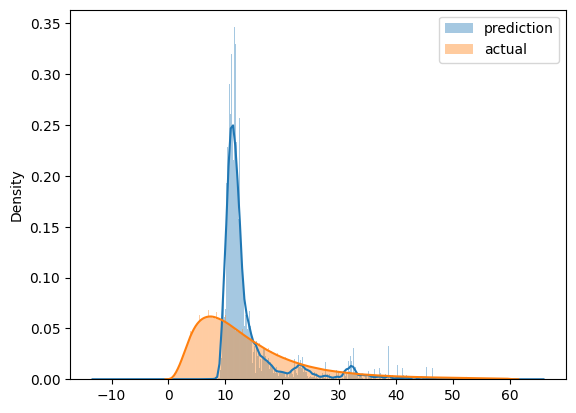

In [18]:
sns.histplot(
    y_pred, kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    label='prediction',
)
sns.histplot(
    y_train, kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    label='actual',
)
plt.legend()
;

## Q6. Evaluating the model

*Apply this model to the validation dataset (February 2023).*

*What's the RMSE on validation?*

In [19]:
def read_dataframe(filename):
    if 'yellow' in filename:
        meter_engaged = 'tpep_pickup_datetime'
        meter_disengaged = 'tpep_dropoff_datetime'
    else:
        meter_engaged = 'lpep_pickup_datetime'
        meter_disengaged = 'lpep_dropoff_datetime'
    

    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df[meter_engaged] = pd.to_datetime(df[meter_engaged])
        df[meter_disengaged] = pd.to_datetime(df[meter_disengaged])
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df[meter_disengaged] - df[meter_engaged]
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [20]:
df_val = read_dataframe('~/mlops-zoomcamp/data/yellow_tripdata_2023-02.parquet')

In [21]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
y_val = df_val[target].values

In [23]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.811821506499323